**Module Import**

In [5]:

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime,date


from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV , RandomizedSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import GradientBoostingRegressor,RandomForestRegressor

from sklearn.metrics import r2_score, mean_squared_error

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import gc

print('Module Imported')

Module Imported


**Booknow Data Load**

In [6]:
booknow_booking = pd.read_csv("/kaggle/input/Cinema_Audience_Forecasting_challenge/booknow_booking/booknow_booking.csv")

booknow_booking['show_datetime'] = pd.to_datetime(booknow_booking['show_datetime']).dt.date
booknow_booking = booknow_booking.groupby(['book_theater_id','show_datetime']).agg({'tickets_booked': 'sum'})
booknow_booking = booknow_booking.reset_index()

booknow_theaters = pd.read_csv("/kaggle/input/Cinema_Audience_Forecasting_challenge/booknow_theaters/booknow_theaters.csv")

booknow_visits = pd.read_csv("/kaggle/input/Cinema_Audience_Forecasting_challenge/booknow_visits/booknow_visits.csv")
booknow_visits ['show_date'] = pd.to_datetime(booknow_visits ['show_date']).dt.date

booknow_visits.head()

,book_theater_id,show_date,audience_count
0,book_00001,2023-01-13,50
1,book_00001,2023-01-14,64
2,book_00001,2023-01-15,58
3,book_00001,2023-01-16,44
4,book_00001,2023-01-18,12


**Cinepos Data Load**

In [7]:
cine_booking = pd.read_csv("/kaggle/input/Cinema_Audience_Forecasting_challenge/cinePOS_booking/cinePOS_booking.csv")
cine_booking['show_datetime'] = pd.to_datetime(cine_booking['show_datetime']).dt.date
cine_booking = cine_booking.groupby(['cine_theater_id','show_datetime']).agg({'tickets_sold': 'sum'})
cine_booking = cine_booking.reset_index()
#cine_booking.info()
cine_theaters = pd.read_csv("/kaggle/input/Cinema_Audience_Forecasting_challenge/cinePOS_theaters/cinePOS_theaters.csv")
cine_booknow_relation = pd.read_csv("/kaggle/input/Cinema_Audience_Forecasting_challenge/movie_theater_id_relation/movie_theater_id_relation.csv")
cinepos = pd.merge(cine_booking,cine_theaters,how="left",on= 'cine_theater_id')
cinepos.head(5)

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,cine_theater_id,show_datetime,tickets_sold,theater_type,theater_area,latitude,longitude
0,cinePOS_00001,2023-01-01,1,NaN,NaN,NaN,NaN
1,cinePOS_00001,2023-01-08,1,NaN,NaN,NaN,NaN
2,cinePOS_00001,2023-01-23,5,NaN,NaN,NaN,NaN
3,cinePOS_00001,2023-01-24,5,NaN,NaN,NaN,NaN
4,cinePOS_00001,2023-01-28,3,NaN,NaN,NaN,NaN


**Booknow & Cinepos Merge**

In [8]:


booknow = pd.merge(booknow_visits,booknow_booking,how="left",left_on= ['book_theater_id','show_date'], right_on = ['book_theater_id','show_datetime'])

booknow = pd.merge(booknow,booknow_theaters,how="left",on='book_theater_id')
booknow = pd.merge(booknow,cine_booknow_relation,how="left",on= 'book_theater_id')
booknow.head(5)

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,book_theater_id,show_date,audience_count,show_datetime,tickets_booked,theater_type,theater_area,latitude,longitude,cine_theater_id
0,book_00001,2023-01-13,50,NaN,NaN,Drama,Area_002,23.00441,79.934515,NaN
1,book_00001,2023-01-14,64,NaN,NaN,Drama,Area_002,23.00441,79.934515,NaN
2,book_00001,2023-01-15,58,NaN,NaN,Drama,Area_002,23.00441,79.934515,NaN
3,book_00001,2023-01-16,44,NaN,NaN,Drama,Area_002,23.00441,79.934515,NaN
4,book_00001,2023-01-18,12,NaN,NaN,Drama,Area_002,23.00441,79.934515,NaN


In [9]:
booknow.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214046 entries, 0 to 214045
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   book_theater_id  214046 non-null  object 
 1   show_date        214046 non-null  object 
 2   audience_count   214046 non-null  int64  
 3   show_datetime    21041 non-null   object 
 4   tickets_booked   21041 non-null   float64
 5   theater_type     80150 non-null   object 
 6   theater_area     80150 non-null   object 
 7   latitude         80150 non-null   float64
 8   longitude        80150 non-null   float64
 9   cine_theater_id  38976 non-null   object 
dtypes: float64(3), int64(1), object(6)
memory usage: 16.3+ MB


In [10]:
cinepos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1120081 entries, 0 to 1120080
Data columns (total 7 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   cine_theater_id  1120081 non-null  object 
 1   show_datetime    1120081 non-null  object 
 2   tickets_sold     1120081 non-null  int64  
 3   theater_type     456002 non-null   object 
 4   theater_area     456002 non-null   object 
 5   latitude         77006 non-null    float64
 6   longitude        77006 non-null    float64
dtypes: float64(2), int64(1), object(4)
memory usage: 59.8+ MB


In [11]:
df = pd.merge(booknow,cinepos,how="left",left_on= ['cine_theater_id','show_date'],right_on = ['cine_theater_id','show_datetime'])
df.head(5)

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,book_theater_id,show_date,audience_count,show_datetime_x,tickets_booked,theater_type_x,theater_area_x,latitude_x,longitude_x,cine_theater_id,show_datetime_y,tickets_sold,theater_type_y,theater_area_y,latitude_y,longitude_y
0,book_00001,2023-01-13,50,NaN,NaN,Drama,Area_002,23.00441,79.934515,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,book_00001,2023-01-14,64,NaN,NaN,Drama,Area_002,23.00441,79.934515,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,book_00001,2023-01-15,58,NaN,NaN,Drama,Area_002,23.00441,79.934515,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,book_00001,2023-01-16,44,NaN,NaN,Drama,Area_002,23.00441,79.934515,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,book_00001,2023-01-18,12,NaN,NaN,Drama,Area_002,23.00441,79.934515,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
# remove the unnecessary dataframes to free memory
del booknow_booking,booknow_theaters,booknow_visits,booknow,cine_booking,cine_theaters,cine_booknow_relation,cinepos
gc.collect()

30

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214046 entries, 0 to 214045
Data columns (total 16 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   book_theater_id  214046 non-null  object 
 1   show_date        214046 non-null  object 
 2   audience_count   214046 non-null  int64  
 3   show_datetime_x  21041 non-null   object 
 4   tickets_booked   21041 non-null   float64
 5   theater_type_x   80150 non-null   object 
 6   theater_area_x   80150 non-null   object 
 7   latitude_x       80150 non-null   float64
 8   longitude_x      80150 non-null   float64
 9   cine_theater_id  38976 non-null   object 
 10  show_datetime_y  11150 non-null   object 
 11  tickets_sold     11150 non-null   float64
 12  theater_type_y   5367 non-null    object 
 13  theater_area_y   5367 non-null    object 
 14  latitude_y       1036 non-null    float64
 15  longitude_y      1036 non-null    float64
dtypes: float64(6), int64(1), object(9)
mem

**EDA & Data Preprocessing**

In [14]:
print(min(df['show_date']),max(df['show_date']))
df.info()

2023-01-01 2024-02-28
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214046 entries, 0 to 214045
Data columns (total 16 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   book_theater_id  214046 non-null  object 
 1   show_date        214046 non-null  object 
 2   audience_count   214046 non-null  int64  
 3   show_datetime_x  21041 non-null   object 
 4   tickets_booked   21041 non-null   float64
 5   theater_type_x   80150 non-null   object 
 6   theater_area_x   80150 non-null   object 
 7   latitude_x       80150 non-null   float64
 8   longitude_x      80150 non-null   float64
 9   cine_theater_id  38976 non-null   object 
 10  show_datetime_y  11150 non-null   object 
 11  tickets_sold     11150 non-null   float64
 12  theater_type_y   5367 non-null    object 
 13  theater_area_y   5367 non-null    object 
 14  latitude_y       1036 non-null    float64
 15  longitude_y      1036 non-null    float64
dtypes: float64(6), i

In [15]:
df.describe()

,audience_count,tickets_booked,latitude_x,longitude_x,tickets_sold,latitude_y,longitude_y
count,214046.000000,21041.000000,80150.000000,80150.000000,11150.000000,1036.000000,1036.000000
mean,41.616568,13.675776,23.108170,78.936323,6.704215,23.345665,79.597989
std,32.834918,18.599312,1.019523,1.490336,7.521122,0.995510,0.866140
min,2.000000,1.000000,22.025970,76.173250,1.000000,22.618118,78.170501
25%,18.000000,5.000000,22.613688,77.970347,2.000000,22.636222,78.222767
50%,34.000000,10.000000,23.004410,79.895175,4.000000,23.018784,79.917573
75%,58.000000,18.000000,23.018784,79.935314,8.000000,23.041649,79.942620
max,1350.000000,1633.000000,26.349436,81.743235,157.000000,25.955746,80.623791


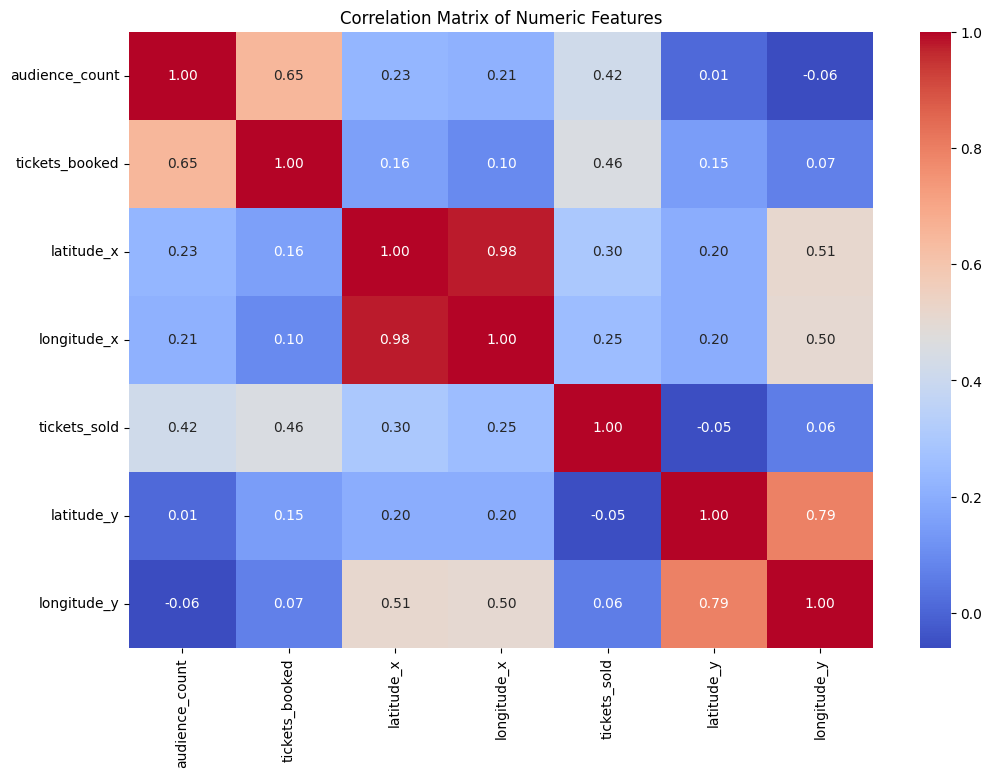

In [16]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.dropna().select_dtypes(include=[np.number]).corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Numeric Features')
plt.show()

In [17]:
#Extract features from date

df['is_weekday'] = pd.to_datetime(df['show_date']).dt.weekday < 5
df['is_weekday']= df['is_weekday'].astype(int)
#df['is_weekday'].unique()
df['year'] = pd.to_datetime(df['show_date']).dt.year
df['month'] = pd.to_datetime(df['show_date']).dt.month
df['date'] = pd.to_datetime(df['show_date']).dt.day
df['daynum'] = pd.to_datetime(df['show_date']).dt.dayofweek
df['week'] = pd.to_datetime(df['show_date']).dt.isocalendar().week
df.head(5)

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pan

,book_theater_id,show_date,audience_count,show_datetime_x,tickets_booked,theater_type_x,theater_area_x,latitude_x,longitude_x,cine_theater_id,...,theater_type_y,theater_area_y,latitude_y,longitude_y,is_weekday,year,month,date,daynum,week
0,book_00001,2023-01-13,50,NaN,NaN,Drama,Area_002,23.00441,79.934515,NaN,...,NaN,NaN,NaN,NaN,1,2023,1,13,4,2
1,book_00001,2023-01-14,64,NaN,NaN,Drama,Area_002,23.00441,79.934515,NaN,...,NaN,NaN,NaN,NaN,0,2023,1,14,5,2
2,book_00001,2023-01-15,58,NaN,NaN,Drama,Area_002,23.00441,79.934515,NaN,...,NaN,NaN,NaN,NaN,0,2023,1,15,6,2
3,book_00001,2023-01-16,44,NaN,NaN,Drama,Area_002,23.00441,79.934515,NaN,...,NaN,NaN,NaN,NaN,1,2023,1,16,0,3
4,book_00001,2023-01-18,12,NaN,NaN,Drama,Area_002,23.00441,79.934515,NaN,...,NaN,NaN,NaN,NaN,1,2023,1,18,2,3


In [18]:
# to check if thatre is available in both 2023 2024
print(df[df['year'] == 2023]['book_theater_id'].nunique())
print(df[df['year'] == 2024]['book_theater_id'].nunique())
df['book_theater_id'].nunique()

819
818


826

                tickets_booked  audience_count
tickets_booked        1.000000        0.447273
audience_count        0.447273        1.000000


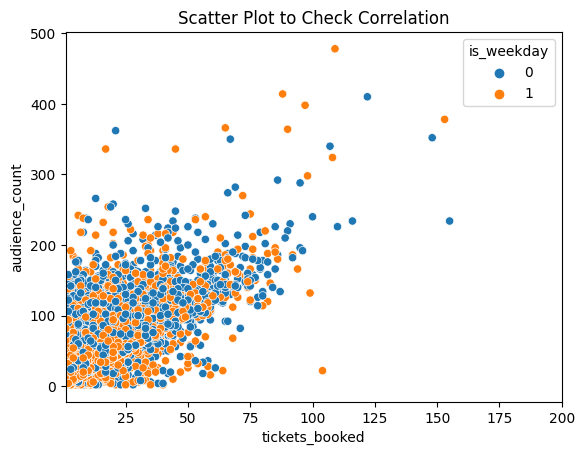

In [19]:
# tickets_booked and audience count correlation check
print(df[['tickets_booked', 'audience_count']].dropna().corr())
sns.scatterplot(data= df[['tickets_booked', 'audience_count','is_weekday']].dropna(), x='tickets_booked', y='audience_count',hue = 'is_weekday')
plt.title("Scatter Plot to Check Correlation")
plt.xlim(1,200)
plt.show()

                tickets_sold  audience_count
tickets_sold        1.000000        0.266643
audience_count      0.266643        1.000000


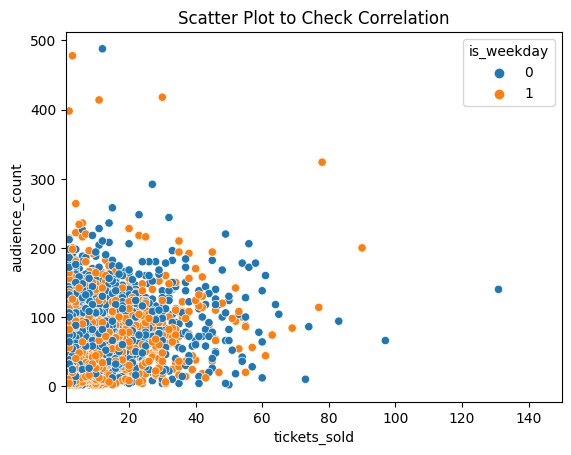

In [20]:
# tickets_sold  and audience count correlation check
print(df[['tickets_sold', 'audience_count']].dropna().corr())
sns.scatterplot(data= df[['tickets_sold', 'audience_count','is_weekday']].dropna(), x='tickets_sold', y='audience_count', hue = 'is_weekday')
plt.title("Scatter Plot to Check Correlation")
plt.xlim(1,150)
plt.show()

                tickets_sold  tickets_booked
tickets_sold        1.000000        0.483644
tickets_booked      0.483644        1.000000


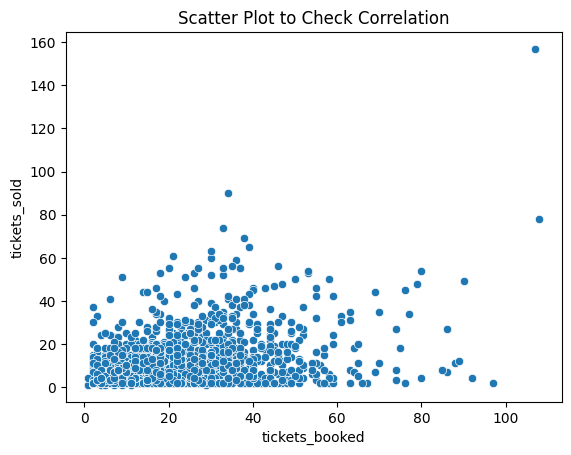

In [21]:
# tickets_sold  and tickets_booked correlation check
print(df[['tickets_sold', 'tickets_booked']].dropna().corr())
sns.scatterplot(data=df[['tickets_sold', 'tickets_booked']].dropna(), x='tickets_booked', y='tickets_sold')
plt.title("Scatter Plot to Check Correlation")
plt.show()

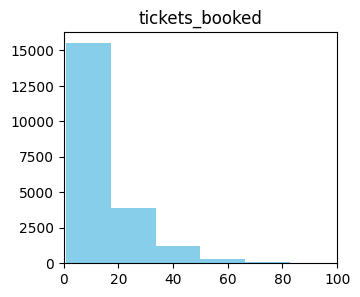

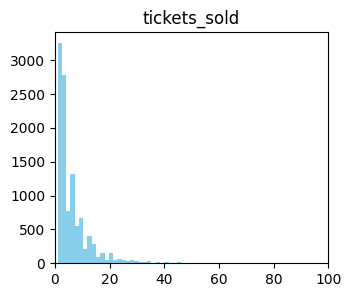

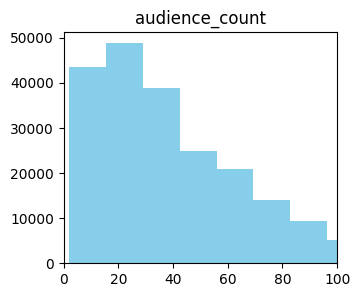

In [22]:
# Distribution analysis

plt.figure(figsize=(12, 3))
plt.subplot(1, 3, 1)
plt.hist(df['tickets_booked'].dropna(), bins=100, color='skyblue')
plt.xlim(0,100)
plt.title("tickets_booked")

plt.figure(figsize=(12, 3))
plt.subplot(1, 3, 2)
plt.hist(df['tickets_sold'].dropna(), bins=100, color='skyblue')
plt.xlim(0,100)
plt.title("tickets_sold")

plt.figure(figsize=(12, 3))
plt.subplot(1, 3, 3)
plt.hist(df['audience_count'], bins=100, color='skyblue')
plt.xlim(0,100)
plt.title("audience_count")

plt.show()

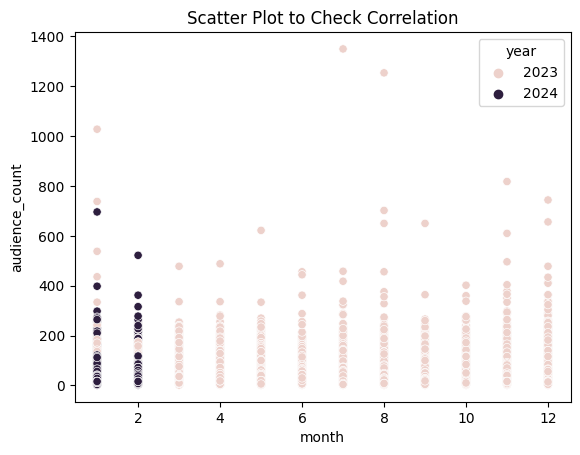

In [23]:
sns.scatterplot(data=df[['audience_count','month', 'year']].dropna(), x='month',
             y='audience_count',hue = 'year' )
plt.title("Scatter Plot to Check Correlation")
plt.show()

<Axes: xlabel='audience_count', ylabel='Count'>

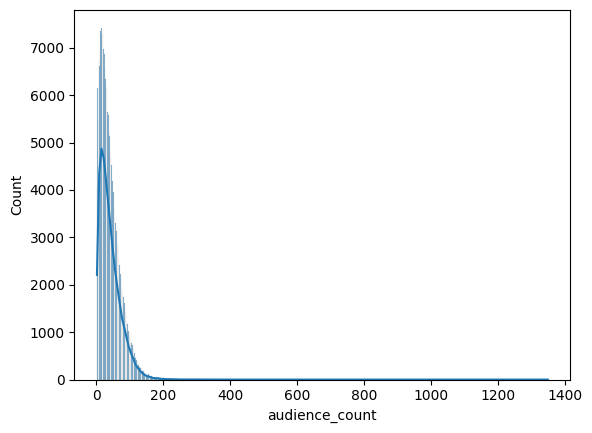

In [24]:
sns.histplot(df['audience_count'], kde = True)

count 375


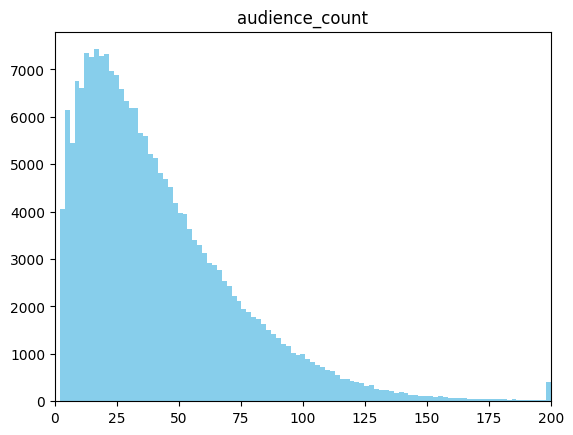

In [25]:
print('count',df[df['audience_count']>200]['audience_count'].count())
#df['audience_count'] = df['audience_count'].apply(lambda x: x if x < 200 else 200)

plt.hist( df['audience_count'].apply(lambda x: x if x < 200 else 200), bins=100, color='skyblue')
plt.xlim(0,200)
plt.title("audience_count")

plt.show()

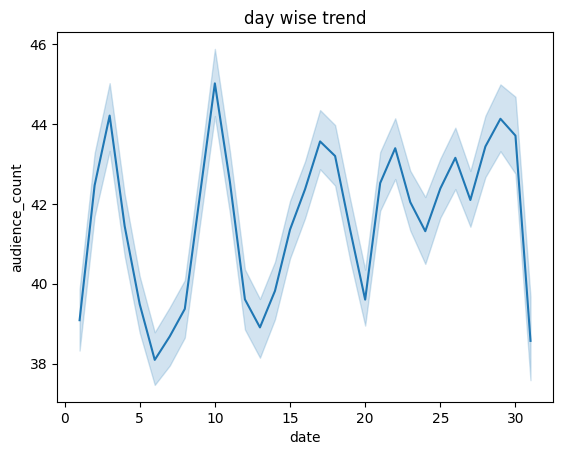

In [26]:
sns.lineplot(data=df[['audience_count','month', 'date']].dropna(), x='date',
             y='audience_count' )
plt.title("day wise trend")
plt.show()

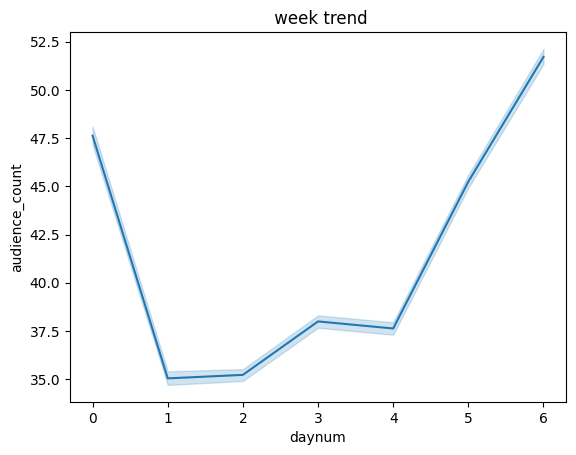

In [27]:
sns.lineplot(data=df[['audience_count','month', 'date','daynum']].dropna(), x='daynum',
             y='audience_count' )
plt.title(" week trend")
plt.show()

**Null Imputation**

In [28]:
# Imputing booknow null values with cinepos dataset values

df['theater_type_x'] = df['theater_type_x'].fillna(df['theater_type_y'])
df['theater_area_x'] = df['theater_area_x'].fillna(df['theater_area_y'])
df['latitude_x'] = df['latitude_x'].fillna(df['latitude_y'])
df['longitude_x'] = df['longitude_x'].fillna(df['longitude_y'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214046 entries, 0 to 214045
Data columns (total 22 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   book_theater_id  214046 non-null  object 
 1   show_date        214046 non-null  object 
 2   audience_count   214046 non-null  int64  
 3   show_datetime_x  21041 non-null   object 
 4   tickets_booked   21041 non-null   float64
 5   theater_type_x   81953 non-null   object 
 6   theater_area_x   81953 non-null   object 
 7   latitude_x       80462 non-null   float64
 8   longitude_x      80462 non-null   float64
 9   cine_theater_id  38976 non-null   object 
 10  show_datetime_y  11150 non-null   object 
 11  tickets_sold     11150 non-null   float64
 12  theater_type_y   5367 non-null    object 
 13  theater_area_y   5367 non-null    object 
 14  latitude_y       1036 non-null    float64
 15  longitude_y      1036 non-null    float64
 16  is_weekday       214046 non-null  int6

In [29]:
# after imputation drop the unnecessary columns

df = df.drop(columns=['show_datetime_x','cine_theater_id',
                      'show_datetime_y','theater_type_y',
                     'theater_area_y','latitude_y','longitude_y'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214046 entries, 0 to 214045
Data columns (total 15 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   book_theater_id  214046 non-null  object 
 1   show_date        214046 non-null  object 
 2   audience_count   214046 non-null  int64  
 3   tickets_booked   21041 non-null   float64
 4   theater_type_x   81953 non-null   object 
 5   theater_area_x   81953 non-null   object 
 6   latitude_x       80462 non-null   float64
 7   longitude_x      80462 non-null   float64
 8   tickets_sold     11150 non-null   float64
 9   is_weekday       214046 non-null  int64  
 10  year             214046 non-null  int32  
 11  month            214046 non-null  int32  
 12  date             214046 non-null  int32  
 13  daynum           214046 non-null  int32  
 14  week             214046 non-null  UInt32 
dtypes: UInt32(1), float64(4), int32(4), int64(2), object(4)
memory usage: 20.6+ MB


In [30]:
# impute the type of the theater with the mode of the theater
type_mapping = (
    df[df['theater_type_x'].notna()].groupby('book_theater_id')['theater_type_x']
    .agg(lambda x: x.mode().iloc[0] if not x.mode().empty else x.iloc[0])
)
df['theater_type_x'] = df['theater_type_x'].fillna(df['book_theater_id'].map(type_mapping))
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214046 entries, 0 to 214045
Data columns (total 15 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   book_theater_id  214046 non-null  object 
 1   show_date        214046 non-null  object 
 2   audience_count   214046 non-null  int64  
 3   tickets_booked   21041 non-null   float64
 4   theater_type_x   86339 non-null   object 
 5   theater_area_x   81953 non-null   object 
 6   latitude_x       80462 non-null   float64
 7   longitude_x      80462 non-null   float64
 8   tickets_sold     11150 non-null   float64
 9   is_weekday       214046 non-null  int64  
 10  year             214046 non-null  int32  
 11  month            214046 non-null  int32  
 12  date             214046 non-null  int32  
 13  daynum           214046 non-null  int32  
 14  week             214046 non-null  UInt32 
dtypes: UInt32(1), float64(4), int32(4), int64(2), object(4)
memory usage: 20.6+ MB


In [31]:
# impute the area of the theater with the mode of the theater
area_mapping = (
    df[df['theater_area_x'].notna()].groupby('book_theater_id')['theater_area_x']
    .agg(lambda x: x.mode().iloc[0] if not x.mode().empty else x.iloc[0])
)
df['theater_area_x'] = df['theater_area_x'].fillna(df['book_theater_id'].map(area_mapping))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214046 entries, 0 to 214045
Data columns (total 15 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   book_theater_id  214046 non-null  object 
 1   show_date        214046 non-null  object 
 2   audience_count   214046 non-null  int64  
 3   tickets_booked   21041 non-null   float64
 4   theater_type_x   86339 non-null   object 
 5   theater_area_x   86339 non-null   object 
 6   latitude_x       80462 non-null   float64
 7   longitude_x      80462 non-null   float64
 8   tickets_sold     11150 non-null   float64
 9   is_weekday       214046 non-null  int64  
 10  year             214046 non-null  int32  
 11  month            214046 non-null  int32  
 12  date             214046 non-null  int32  
 13  daynum           214046 non-null  int32  
 14  week             214046 non-null  UInt32 
dtypes: UInt32(1), float64(4), int32(4), int64(2), object(4)
memory usage: 20.6+ MB


In [32]:
# checking the records with latitude null and area not null to impute area column
df[df['latitude_x'].notna() & df['theater_area_x'].isna()]

,book_theater_id,show_date,audience_count,tickets_booked,theater_type_x,theater_area_x,latitude_x,longitude_x,tickets_sold,is_weekday,year,month,date,daynum,week


In [33]:
# remaining area and type null records impute with mode
df['theater_type_x'] = df['theater_type_x'].fillna(df['theater_type_x'].mode()[0])
df['theater_area_x'] = df['theater_area_x'].fillna(df['theater_area_x'].mode()[0])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214046 entries, 0 to 214045
Data columns (total 15 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   book_theater_id  214046 non-null  object 
 1   show_date        214046 non-null  object 
 2   audience_count   214046 non-null  int64  
 3   tickets_booked   21041 non-null   float64
 4   theater_type_x   214046 non-null  object 
 5   theater_area_x   214046 non-null  object 
 6   latitude_x       80462 non-null   float64
 7   longitude_x      80462 non-null   float64
 8   tickets_sold     11150 non-null   float64
 9   is_weekday       214046 non-null  int64  
 10  year             214046 non-null  int32  
 11  month            214046 non-null  int32  
 12  date             214046 non-null  int32  
 13  daynum           214046 non-null  int32  
 14  week             214046 non-null  UInt32 
dtypes: UInt32(1), float64(4), int32(4), int64(2), object(4)
memory usage: 20.6+ MB


In [34]:
# Impute latitude and longitude with the mode of the thater id. 

lat_id_mapping = (
    df[df['latitude_x'].notna()]
    .groupby('book_theater_id')['latitude_x']
    .agg(lambda x: x.mode().iloc[0] if not x.mode().empty else x.iloc[0])
)

lon_id_mapping = (
    df[df['longitude_x'].notna()]
    .groupby('book_theater_id')['longitude_x']
    .agg(lambda x: x.mode().iloc[0] if not x.mode().empty else x.iloc[0])
)

df['latitude_x'] = df['latitude_x'].fillna(df['book_theater_id'].map(lat_id_mapping))

df['longitude_x'] = df['longitude_x'].fillna(df['book_theater_id'].map(lon_id_mapping))

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214046 entries, 0 to 214045
Data columns (total 15 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   book_theater_id  214046 non-null  object 
 1   show_date        214046 non-null  object 
 2   audience_count   214046 non-null  int64  
 3   tickets_booked   21041 non-null   float64
 4   theater_type_x   214046 non-null  object 
 5   theater_area_x   214046 non-null  object 
 6   latitude_x       81265 non-null   float64
 7   longitude_x      81265 non-null   float64
 8   tickets_sold     11150 non-null   float64
 9   is_weekday       214046 non-null  int64  
 10  year             214046 non-null  int32  
 11  month            214046 non-null  int32  
 12  date             214046 non-null  int32  
 13  daynum           214046 non-null  int32  
 14  week             214046 non-null  UInt32 
dtypes: UInt32(1), float64(4), int32(4), int64(2), object(4)
memory usage: 20.6+ MB


In [35]:
# Impute latitude and longitude with the mode of the area. 

latitude_mapping = (
    df[df['latitude_x'].notna()].groupby('theater_area_x')['latitude_x']
    .agg(lambda x: x.mode().iloc[0] if not x.mode().empty else x.iloc[0])
)

longitude_mapping = (
    df[df['longitude_x'].notna()].groupby('theater_area_x')['longitude_x']
    .agg(lambda x: x.mode().iloc[0] if not x.mode().empty else x.iloc[0])
)

df['latitude_x'] = df['latitude_x'].fillna(df['theater_area_x'].map(latitude_mapping))

df['longitude_x'] = df['longitude_x'].fillna(df['theater_area_x'].map(longitude_mapping))

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214046 entries, 0 to 214045
Data columns (total 15 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   book_theater_id  214046 non-null  object 
 1   show_date        214046 non-null  object 
 2   audience_count   214046 non-null  int64  
 3   tickets_booked   21041 non-null   float64
 4   theater_type_x   214046 non-null  object 
 5   theater_area_x   214046 non-null  object 
 6   latitude_x       209828 non-null  float64
 7   longitude_x      209828 non-null  float64
 8   tickets_sold     11150 non-null   float64
 9   is_weekday       214046 non-null  int64  
 10  year             214046 non-null  int32  
 11  month            214046 non-null  int32  
 12  date             214046 non-null  int32  
 13  daynum           214046 non-null  int32  
 14  week             214046 non-null  UInt32 
dtypes: UInt32(1), float64(4), int32(4), int64(2), object(4)
memory usage: 20.6+ MB


In [36]:
# Impute numerics with median of the day - Right skewed data

ticket_booked_mapping = (
    df[df['tickets_booked'].notna()]
      .groupby('show_date')['tickets_booked']
      .median()
 )

df['tickets_booked'] = df['tickets_booked'].fillna(
    df['show_date'].map(ticket_booked_mapping)
 )

tickets_sold_mapping = (
    df[df['tickets_sold'].notna()]
      .groupby('show_date')['tickets_sold']
      .median()
 )
df['tickets_sold'] = df['tickets_sold'].fillna(
    df['show_date'].map(tickets_sold_mapping)
 )
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214046 entries, 0 to 214045
Data columns (total 15 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   book_theater_id  214046 non-null  object 
 1   show_date        214046 non-null  object 
 2   audience_count   214046 non-null  int64  
 3   tickets_booked   155244 non-null  float64
 4   theater_type_x   214046 non-null  object 
 5   theater_area_x   214046 non-null  object 
 6   latitude_x       209828 non-null  float64
 7   longitude_x      209828 non-null  float64
 8   tickets_sold     213778 non-null  float64
 9   is_weekday       214046 non-null  int64  
 10  year             214046 non-null  int32  
 11  month            214046 non-null  int32  
 12  date             214046 non-null  int32  
 13  daynum           214046 non-null  int32  
 14  week             214046 non-null  UInt32 
dtypes: UInt32(1), float64(4), int32(4), int64(2), object(4)
memory usage: 20.6+ MB


In [37]:
# impute all remaining values with median or mode

df['latitude_x'] = df['latitude_x'].fillna(df['latitude_x'].mode()[0])
df['longitude_x'] = df['longitude_x'].fillna(df['longitude_x'].mode()[0])

df['tickets_booked'] = df['tickets_booked'].fillna(df['tickets_booked'].median())
df['tickets_sold'] = df['tickets_sold'].fillna(df['tickets_sold'].median())
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214046 entries, 0 to 214045
Data columns (total 15 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   book_theater_id  214046 non-null  object 
 1   show_date        214046 non-null  object 
 2   audience_count   214046 non-null  int64  
 3   tickets_booked   214046 non-null  float64
 4   theater_type_x   214046 non-null  object 
 5   theater_area_x   214046 non-null  object 
 6   latitude_x       214046 non-null  float64
 7   longitude_x      214046 non-null  float64
 8   tickets_sold     214046 non-null  float64
 9   is_weekday       214046 non-null  int64  
 10  year             214046 non-null  int32  
 11  month            214046 non-null  int32  
 12  date             214046 non-null  int32  
 13  daynum           214046 non-null  int32  
 14  week             214046 non-null  UInt32 
dtypes: UInt32(1), float64(4), int32(4), int64(2), object(4)
memory usage: 20.6+ MB


In [38]:
# convert thater id and area to int by extracting the numeric part.

df['book_theater_id'] = df['book_theater_id'].str.extract(r'(\d+)').astype(int)
df['theater_area_x'] = df['theater_area_x'].str.extract(r'(\d+)').astype(int)
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214046 entries, 0 to 214045
Data columns (total 15 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   book_theater_id  214046 non-null  int64  
 1   show_date        214046 non-null  object 
 2   audience_count   214046 non-null  int64  
 3   tickets_booked   214046 non-null  float64
 4   theater_type_x   214046 non-null  object 
 5   theater_area_x   214046 non-null  int64  
 6   latitude_x       214046 non-null  float64
 7   longitude_x      214046 non-null  float64
 8   tickets_sold     214046 non-null  float64
 9   is_weekday       214046 non-null  int64  
 10  year             214046 non-null  int32  
 11  month            214046 non-null  int32  
 12  date             214046 non-null  int32  
 13  daynum           214046 non-null  int32  
 14  week             214046 non-null  UInt32 
dtypes: UInt32(1), float64(4), int32(4), int64(4), object(2)
memory usage: 20.6+ MB


**Validation dataset Preparation**

In [39]:
# data loading
submission = pd.read_csv('/kaggle/input/Cinema_Audience_Forecasting_challenge/sample_submission/sample_submission.csv')

submission['book_theater_id'] = submission['ID'].apply(lambda x : x[5:10]).astype(int)
submission['date'] = submission['ID'].apply(lambda x : x[11:])
submission.head()

,ID,audience_count,book_theater_id,date
0,book_00001_2024-03-01,0,1,2024-03-01
1,book_00001_2024-03-02,0,1,2024-03-02
2,book_00001_2024-03-03,0,1,2024-03-03
3,book_00001_2024-03-04,0,1,2024-03-04
4,book_00001_2024-03-06,0,1,2024-03-06


In [40]:
print(min(submission['date'])), print(max(submission['date']))

2024-03-01
2024-04-22


(None, None)

In [41]:
#createing a dataframe to join and get the same columns as training
details_df = df.groupby(['book_theater_id','theater_type_x','theater_area_x'
                        ,'latitude_x',
                   'longitude_x']).size().reset_index()
details_df.head()

,book_theater_id,theater_type_x,theater_area_x,latitude_x,longitude_x,0
0,1,Drama,2,23.004410,79.934515,342
1,2,Other,27,22.611676,78.228299,288
2,3,Other,25,26.249437,80.979803,240
3,4,Other,29,24.048814,80.382037,366
4,5,Action,8,22.495681,77.015883,243


In [42]:
#Extract features from date
submission['show_date'] = pd.to_datetime(submission['date'],errors='coerce')
submission['is_weekday'] = submission['show_date'].dt.weekday < 5
submission['is_weekday']= submission['is_weekday'].astype(int)
#df['is_weekday'].unique()
submission['year'] = submission['show_date'].dt.year
submission['month'] = submission['show_date'].dt.month
submission['date'] = submission['show_date'].dt.day
submission['daynum'] = submission['show_date'].dt.dayofweek
submission.head()

,ID,audience_count,book_theater_id,date,show_date,is_weekday,year,month,daynum
0,book_00001_2024-03-01,0,1,1,2024-03-01,1,2024,3,4
1,book_00001_2024-03-02,0,1,2,2024-03-02,0,2024,3,5
2,book_00001_2024-03-03,0,1,3,2024-03-03,0,2024,3,6
3,book_00001_2024-03-04,0,1,4,2024-03-04,1,2024,3,0
4,book_00001_2024-03-06,0,1,6,2024-03-06,1,2024,3,2


In [43]:
# merge sumbission and details df
submission = pd.merge(submission,details_df,how = 'left', on = ['book_theater_id'])

submission.head(5)

,ID,audience_count,book_theater_id,date,show_date,is_weekday,year,month,daynum,theater_type_x,theater_area_x,latitude_x,longitude_x,0
0,book_00001_2024-03-01,0,1,1,2024-03-01,1,2024,3,4,Drama,2.0,23.00441,79.934515,342.0
1,book_00001_2024-03-02,0,1,2,2024-03-02,0,2024,3,5,Drama,2.0,23.00441,79.934515,342.0
2,book_00001_2024-03-03,0,1,3,2024-03-03,0,2024,3,6,Drama,2.0,23.00441,79.934515,342.0
3,book_00001_2024-03-04,0,1,4,2024-03-04,1,2024,3,0,Drama,2.0,23.00441,79.934515,342.0
4,book_00001_2024-03-06,0,1,6,2024-03-06,1,2024,3,2,Drama,2.0,23.00441,79.934515,342.0


In [44]:
submission.info()

# the records with null represent the theater's not available in training but available in the validation set

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38062 entries, 0 to 38061
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   ID               38062 non-null  object        
 1   audience_count   38062 non-null  int64         
 2   book_theater_id  38062 non-null  int64         
 3   date             38062 non-null  int32         
 4   show_date        38062 non-null  datetime64[ns]
 5   is_weekday       38062 non-null  int64         
 6   year             38062 non-null  int32         
 7   month            38062 non-null  int32         
 8   daynum           38062 non-null  int32         
 9   theater_type_x   37944 non-null  object        
 10  theater_area_x   37944 non-null  float64       
 11  latitude_x       37944 non-null  float64       
 12  longitude_x      37944 non-null  float64       
 13  0                37944 non-null  float64       
dtypes: datetime64[ns](1), float64(4), int3

In [45]:
# Impute type and area of the theater with mode

submission['theater_type_x'] = submission['theater_type_x'].fillna(df['theater_type_x'].mode()[0])
submission['theater_area_x'] = submission['theater_area_x'].fillna(df['theater_area_x'].mode()[0])

submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38062 entries, 0 to 38061
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   ID               38062 non-null  object        
 1   audience_count   38062 non-null  int64         
 2   book_theater_id  38062 non-null  int64         
 3   date             38062 non-null  int32         
 4   show_date        38062 non-null  datetime64[ns]
 5   is_weekday       38062 non-null  int64         
 6   year             38062 non-null  int32         
 7   month            38062 non-null  int32         
 8   daynum           38062 non-null  int32         
 9   theater_type_x   38062 non-null  object        
 10  theater_area_x   38062 non-null  float64       
 11  latitude_x       37944 non-null  float64       
 12  longitude_x      37944 non-null  float64       
 13  0                37944 non-null  float64       
dtypes: datetime64[ns](1), float64(4), int3

In [46]:
# impute latitude and longitude with the mode of the area

submission['latitude_x'] = submission['latitude_x'].fillna(submission['theater_area_x'].map(latitude_mapping))


submission['longitude_x'] = submission['longitude_x'].fillna(submission['theater_area_x'].map(longitude_mapping))

submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38062 entries, 0 to 38061
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   ID               38062 non-null  object        
 1   audience_count   38062 non-null  int64         
 2   book_theater_id  38062 non-null  int64         
 3   date             38062 non-null  int32         
 4   show_date        38062 non-null  datetime64[ns]
 5   is_weekday       38062 non-null  int64         
 6   year             38062 non-null  int32         
 7   month            38062 non-null  int32         
 8   daynum           38062 non-null  int32         
 9   theater_type_x   38062 non-null  object        
 10  theater_area_x   38062 non-null  float64       
 11  latitude_x       37944 non-null  float64       
 12  longitude_x      37944 non-null  float64       
 13  0                37944 non-null  float64       
dtypes: datetime64[ns](1), float64(4), int3

In [47]:
# Remaining nulls impute with mode

submission['latitude_x'] = submission['latitude_x'].fillna(submission['latitude_x'].mode()[0])
submission['longitude_x'] = submission['longitude_x'].fillna(submission['longitude_x'].mode()[0])
submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38062 entries, 0 to 38061
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   ID               38062 non-null  object        
 1   audience_count   38062 non-null  int64         
 2   book_theater_id  38062 non-null  int64         
 3   date             38062 non-null  int32         
 4   show_date        38062 non-null  datetime64[ns]
 5   is_weekday       38062 non-null  int64         
 6   year             38062 non-null  int32         
 7   month            38062 non-null  int32         
 8   daynum           38062 non-null  int32         
 9   theater_type_x   38062 non-null  object        
 10  theater_area_x   38062 non-null  float64       
 11  latitude_x       38062 non-null  float64       
 12  longitude_x      38062 non-null  float64       
 13  0                37944 non-null  float64       
dtypes: datetime64[ns](1), float64(4), int3

In [48]:
#create a new df lag to union with the submission df to create lag features

col = ['book_theater_id', 'show_date','theater_type_x',
         'is_weekday','year', 'month', 'date', 'daynum',
        'latitude_x','longitude_x',
        'theater_area_x','audience_count']

lag_df = df[col]


lag_df.head()

,book_theater_id,show_date,theater_type_x,is_weekday,year,month,date,daynum,latitude_x,longitude_x,theater_area_x,audience_count
0,1,2023-01-13,Drama,1,2023,1,13,4,23.00441,79.934515,2,50
1,1,2023-01-14,Drama,0,2023,1,14,5,23.00441,79.934515,2,64
2,1,2023-01-15,Drama,0,2023,1,15,6,23.00441,79.934515,2,58
3,1,2023-01-16,Drama,1,2023,1,16,0,23.00441,79.934515,2,44
4,1,2023-01-18,Drama,1,2023,1,18,2,23.00441,79.934515,2,12


In [49]:
# union lag and submission

lag_df['show_date'] = pd.to_datetime(lag_df['show_date'])
lag_df = pd.concat(
    [lag_df[col], submission[col]],
    axis=0
).reset_index(drop=True)


lag_df = lag_df.sort_values(['book_theater_id','show_date'])
lag_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 252108 entries, 0 to 252107
Data columns (total 12 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   book_theater_id  252108 non-null  int64         
 1   show_date        252108 non-null  datetime64[ns]
 2   theater_type_x   252108 non-null  object        
 3   is_weekday       252108 non-null  int64         
 4   year             252108 non-null  int32         
 5   month            252108 non-null  int32         
 6   date             252108 non-null  int32         
 7   daynum           252108 non-null  int32         
 8   latitude_x       252108 non-null  float64       
 9   longitude_x      252108 non-null  float64       
 10  theater_area_x   252108 non-null  float64       
 11  audience_count   252108 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int32(4), int64(3), object(1)
memory usage: 21.2+ MB


/tmp/ipykernel_38/3131446378.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lag_df['show_date'] = pd.to_datetime(lag_df['show_date'])


In [50]:
# add lag features

lag_features = [1, 2, 7]  
for lag in lag_features:
    lag_df[f'lag_{lag}'] = lag_df.groupby('book_theater_id')['audience_count'].shift(lag)

lag_df[lag_df['book_theater_id'] ==2].head(8)

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,book_theater_id,show_date,theater_type_x,is_weekday,year,month,date,daynum,latitude_x,longitude_x,theater_area_x,audience_count,lag_1,lag_2,lag_7
342,2,2023-01-05,Other,1,2023,1,5,3,22.611676,78.228299,27.0,24,NaN,NaN,NaN
343,2,2023-01-06,Other,1,2023,1,6,4,22.611676,78.228299,27.0,56,24.0,NaN,NaN
344,2,2023-01-07,Other,0,2023,1,7,5,22.611676,78.228299,27.0,12,56.0,24.0,NaN
345,2,2023-01-08,Other,0,2023,1,8,6,22.611676,78.228299,27.0,16,12.0,56.0,NaN
346,2,2023-01-09,Other,1,2023,1,9,0,22.611676,78.228299,27.0,26,16.0,12.0,NaN
347,2,2023-01-10,Other,1,2023,1,10,1,22.611676,78.228299,27.0,28,26.0,16.0,NaN
348,2,2023-01-11,Other,1,2023,1,11,2,22.611676,78.228299,27.0,4,28.0,26.0,NaN
349,2,2023-01-13,Other,1,2023,1,13,4,22.611676,78.228299,27.0,42,4.0,28.0,24.0


In [51]:
# impute the missing values in the lag columns
id_lag_map = lag_df[lag_df['audience_count'] != 0].groupby('book_theater_id')['audience_count'].mean().to_dict()
area_lag_map = lag_df[lag_df['audience_count'] != 0].groupby('theater_area_x')['audience_count'].mean().to_dict()
global_mean = lag_df[lag_df['audience_count'] != 0]['audience_count'].mean()

def lag_map(col_list,lag_df,area_lag_map,id_lag_map):
    for col in col_list:
        lag_df[col] = lag_df.apply(
                lambda x: (
                    id_lag_map.get(x['book_theater_id'],
                                    area_lag_map.get(x['theater_area_x'], global_mean)
                                  )
                if pd.isna(x[col]) else x[col]
            ),
            axis=1
        )

lag_map(['lag_1','lag_2','lag_7'],lag_df,area_lag_map,id_lag_map)

lag_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 252108 entries, 0 to 252107
Data columns (total 15 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   book_theater_id  252108 non-null  int64         
 1   show_date        252108 non-null  datetime64[ns]
 2   theater_type_x   252108 non-null  object        
 3   is_weekday       252108 non-null  int64         
 4   year             252108 non-null  int32         
 5   month            252108 non-null  int32         
 6   date             252108 non-null  int32         
 7   daynum           252108 non-null  int32         
 8   latitude_x       252108 non-null  float64       
 9   longitude_x      252108 non-null  float64       
 10  theater_area_x   252108 non-null  float64       
 11  audience_count   252108 non-null  int64         
 12  lag_1            252108 non-null  float64       
 13  lag_2            252108 non-null  float64       
 14  lag_7            252108 n

In [52]:
lag_df[lag_df['audience_count'] != 0].head(10)

,book_theater_id,show_date,theater_type_x,is_weekday,year,month,date,daynum,latitude_x,longitude_x,theater_area_x,audience_count,lag_1,lag_2,lag_7
0,1,2023-01-13,Drama,1,2023,1,13,4,23.00441,79.934515,2.0,50,47.05848,47.05848,47.05848
1,1,2023-01-14,Drama,0,2023,1,14,5,23.00441,79.934515,2.0,64,50.00000,47.05848,47.05848
2,1,2023-01-15,Drama,0,2023,1,15,6,23.00441,79.934515,2.0,58,64.00000,50.00000,47.05848
3,1,2023-01-16,Drama,1,2023,1,16,0,23.00441,79.934515,2.0,44,58.00000,64.00000,47.05848
4,1,2023-01-18,Drama,1,2023,1,18,2,23.00441,79.934515,2.0,12,44.00000,58.00000,47.05848
5,1,2023-01-19,Drama,1,2023,1,19,3,23.00441,79.934515,2.0,18,12.00000,44.00000,47.05848
6,1,2023-01-20,Drama,1,2023,1,20,4,23.00441,79.934515,2.0,62,18.00000,12.00000,47.05848
7,1,2023-01-21,Drama,0,2023,1,21,5,23.00441,79.934515,2.0,42,62.00000,18.00000,50.00000
8,1,2023-01-22,Drama,0,2023,1,22,6,23.00441,79.934515,2.0,36,42.00000,62.00000,64.00000
9,1,2023-01-23,Drama,1,2023,1,23,0,23.00441,79.934515,2.0,52,36.00000,42.00000,58.00000


In [53]:
# to check if thatre is available in both 2023 2024
print(df[df['year'] == 2023]['book_theater_id'].nunique())
print(df[df['year'] == 2024]['book_theater_id'].nunique())

id_2023 = set(df[df['year'] == 2023]['book_theater_id'].unique())

id_2024 = set(df[df['year'] == 2024]['book_theater_id'].unique())

diff = set.difference(id_2024,id_2023)

diff


819
818


{105, 152, 265, 368, 505, 506, 581}

In [54]:
df[df['book_theater_id'].isin(diff)]

,book_theater_id,show_date,audience_count,tickets_booked,theater_type_x,theater_area_x,latitude_x,longitude_x,tickets_sold,is_weekday,year,month,date,daynum,week
26365,105,2024-02-15,10,44.0,Other,59,22.165811,76.204447,4.0,1,2024,2,15,3,7
38968,152,2024-01-27,8,13.0,Drama,2,23.004410,79.934515,8.0,0,2024,1,27,5,4
38969,152,2024-01-30,8,7.0,Drama,2,23.004410,79.934515,3.0,1,2024,1,30,1,5
38970,152,2024-01-31,4,7.0,Drama,2,23.004410,79.934515,5.0,1,2024,1,31,2,5
38971,152,2024-02-01,6,7.0,Drama,2,23.004410,79.934515,4.0,1,2024,2,1,3,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149094,581,2024-02-24,62,12.0,Other,3,22.176869,76.191001,6.0,0,2024,2,24,5,8
149095,581,2024-02-25,70,16.0,Other,3,22.176869,76.191001,6.0,0,2024,2,25,6,8
149096,581,2024-02-26,70,10.0,Other,3,22.176869,76.191001,4.0,1,2024,2,26,0,9
149097,581,2024-02-27,66,8.0,Other,3,22.176869,76.191001,4.0,1,2024,2,27,1,9


In [55]:
df = df.sort_values(['book_theater_id','show_date'])
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=4)
for train_idx, test_idx in tscv.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[test_idx]
    print(max(train['show_date']))
    print(train['show_date'].count())

# if i use timeseries split theaters not available in 2023 will get included in all training splits.

2024-02-28
42810
2024-02-28
85619
2024-02-28
128428
2024-02-28
171237


**Model Development**

In [56]:
#train test split

x= lag_df[lag_df['audience_count'] != 0].drop(columns = ['show_date','audience_count'])
y = lag_df[lag_df['audience_count'] != 0]['audience_count']

x_train = lag_df[(lag_df['audience_count'] != 0) & (lag_df['show_date'] <= '2024-01-31')
                ].drop(columns = ['show_date','audience_count'])
y_train = lag_df[(lag_df['audience_count'] != 0) & (lag_df['show_date'] <= '2024-01-31')
                ]['audience_count']

x_test = lag_df[(lag_df['audience_count'] != 0) & (lag_df['show_date'] > '2024-01-31')
                ].drop(columns = ['show_date','audience_count'])
y_test = lag_df[(lag_df['audience_count'] != 0) & (lag_df['show_date'] > '2024-01-31')
                ]['audience_count']


x.info()


<class 'pandas.core.frame.DataFrame'>
Index: 214046 entries, 0 to 214045
Data columns (total 13 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   book_theater_id  214046 non-null  int64  
 1   theater_type_x   214046 non-null  object 
 2   is_weekday       214046 non-null  int64  
 3   year             214046 non-null  int32  
 4   month            214046 non-null  int32  
 5   date             214046 non-null  int32  
 6   daynum           214046 non-null  int32  
 7   latitude_x       214046 non-null  float64
 8   longitude_x      214046 non-null  float64
 9   theater_area_x   214046 non-null  float64
 10  lag_1            214046 non-null  float64
 11  lag_2            214046 non-null  float64
 12  lag_7            214046 non-null  float64
dtypes: float64(6), int32(4), int64(2), object(1)
memory usage: 19.6+ MB


In [57]:
# custome target encoder function to create a new column 

from sklearn.base import BaseEstimator, TransformerMixin

class CustomTargetEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, encode_col=None,
                 backup_col=None, 
                 strategy = None,
                 create_new_column = 'Y'
                ):
        self.encode_col = encode_col
        self.backup_col = backup_col
        self.encode_map = None
        self.backup_map = None
        self.global_mean = None
        self.strategy = strategy
        self.create_new_column = create_new_column

    def fit(self, X, y):
        df = X.copy()
        df['target'] = y

        if self.strategy == 'median':
            self.global_mean = y.median()
            self.encode_map = df.groupby(self.encode_col)['target'].median().to_dict()
            self.backup_map = df.groupby(self.backup_col)['target'].median().to_dict()
        elif self.strategy == 'mean':
            self.global_mean = y.mean()
            self.encode_map = df.groupby(self.encode_col)['target'].mean().to_dict()
            self.backup_map = df.groupby(self.backup_col)['target'].mean().to_dict()
        else:
            self.global_mean = y.mode()
            self.encode_map = df.groupby(self.encode_col)['target'].mode().to_dict()
            self.backup_map = df.groupby(self.backup_col)['target'].mode().to_dict()

        return self

    def transform(self, X):
        X = X.copy()

        if self.create_new_column == 'Y':
            col_name = f'{self.encode_col}_1'
        else:
            col_name = f'{self.encode_col}'

        # primary encoding with target mean
        X[col_name] = X[self.encode_col].map(self.encode_map)

        # To handle unknown theaters in the submission imputing with backup col and target mean
        X[col_name] = X.apply(
            lambda row: self.backup_map.get(row[self.backup_col], self.global_mean)
            if pd.isna(row[col_name]) else row[col_name],
            axis=1
        )

        return X
        
print('success')

success


**Gradient Boosting**

In [58]:


gbr = GradientBoostingRegressor(random_state=42)

gbr_cols = ['is_weekday', 'year', 'month', 'date', 'daynum', #'latitude_x','longitude_x',
    'book_theater_id','theater_area_x', 'theater_type_x'
           ,'lag_1','lag_2','lag_7'
           ]

gbr_colt = ColumnTransformer(transformers=[
    ('one-hot', OneHotEncoder(handle_unknown='ignore'), ['theater_type_x'])
],remainder= 'passthrough')



gbr_pipe = Pipeline(steps=[
    ('target_encode',CustomTargetEncoder(encode_col = 'book_theater_id',  backup_col='theater_area_x',strategy = 'mean')),  
    ('preprocessor', gbr_colt),                
    ('regressor', gbr)                       
])

gbr_param_dist = {
    'regressor__n_estimators': [100, 200, 300, 400],
    'regressor__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'regressor__max_depth': [3, 4, 5, 6],
    'regressor__subsample': [0.6, 0.8, 1.0],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4],
    'regressor__max_features': ['sqrt', 'log2', None] #Number of features to consider when looking for the best split.
}


gbr_Rcv = RandomizedSearchCV(
    estimator=gbr_pipe,
    param_distributions=gbr_param_dist,
    n_iter=50,
    cv=5,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1,
    random_state=42
)

'''
gbr_Rcv.fit(x_train[gbr_cols], y_train)


gbr_best_model = gbr_Rcv.best_estimator_


gbr_pred = gbr_best_model.predict(x_train[gbr_cols])


print("Train R² Score:", r2_score(y_train, gbr_pred))
print("Train MSE Score:", mean_squared_error(y_train, gbr_pred))
print("Best Params:", gbr_Rcv.best_params_)

gbr_pred1 = gbr_best_model.predict(x_test[gbr_cols])

print("test R² Score:", r2_score(y_test, gbr_pred1))
print("test MSE Score:", mean_squared_error(y_test, gbr_pred1))
'''

'\ngbr_Rcv.fit(x_train[gbr_cols], y_train)\n\n\ngbr_best_model = gbr_Rcv.best_estimator_\n\n\ngbr_pred = gbr_best_model.predict(x_train[gbr_cols])\n\n\nprint("Train R² Score:", r2_score(y_train, gbr_pred))\nprint("Train MSE Score:", mean_squared_error(y_train, gbr_pred))\nprint("Best Params:", gbr_Rcv.best_params_)\n\ngbr_pred1 = gbr_best_model.predict(x_test[gbr_cols])\n\nprint("test R² Score:", r2_score(y_test, gbr_pred1))\nprint("test MSE Score:", mean_squared_error(y_test, gbr_pred1))\n'

In [ ]:
gbr_config = {'regressor__subsample': 1.0, 'regressor__n_estimators': 400, 
              'regressor__min_samples_split': 2, 'regressor__min_samples_leaf': 4,
              'regressor__max_features': 'log2',
              'regressor__max_depth': 6, 'regressor__learning_rate': 0.1}

#gbr_config = gbr_Rcv.best_params_

#gbr_config ['regressor__n_estimators'] = 150

gbr1 = GradientBoostingRegressor(random_state=42)


gbr_pipe1 = Pipeline(steps=[
    ('target_encode',CustomTargetEncoder(encode_col = 'book_theater_id',  backup_col='theater_area_x',strategy = 'mean')),  
    ('preprocessor', gbr_colt),                
    ('regressor', gbr1)                       
])

# set parameter in the pipeline
gbr_pipe1.set_params(**gbr_config) 

gbr_pipe1.fit(x_train[gbr_cols], y_train)

gbr_pipe1_pred = gbr_pipe1.predict(x_train[gbr_cols])


print("Train R² Score:", r2_score(y_train, gbr_pipe1_pred))
print("Train MSE Score:", mean_squared_error(y_train, gbr_pipe1_pred))

gbr_pipe2_pred = gbr_pipe1.predict(x_test[gbr_cols])

print("test R² Score:", r2_score(y_test, gbr_pipe2_pred))
print("test MSE Score:", mean_squared_error(y_test, gbr_pipe2_pred))

# refit on full dataset

gbr_pipe1.fit(x[gbr_cols], y)

gbr_pipe1_final_pred = gbr_pipe1.predict(x[gbr_cols])

print('Refit scores on all the data')
print("Train R² Score:", r2_score(y, gbr_pipe1_final_pred))
print("Train MSE Score:", mean_squared_error(y, gbr_pipe1_final_pred))

**Xgboost**

In [ ]:


xgb_cols = ['is_weekday', 'year', 'month', 'date', 'daynum', #'latitude_x','longitude_x',
    'book_theater_id','theater_area_x', 'theater_type_x'
           ,'lag_1','lag_2','lag_7'
           ]


xgb = XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    verbosity=0
)


xgb_colt = ColumnTransformer(transformers=[
    ('one-hot', OneHotEncoder(handle_unknown='ignore'), ['theater_type_x'])
],remainder= 'passthrough')



xgb_pipe = Pipeline(steps=[
    ('target_encode',CustomTargetEncoder(encode_col = 'book_theater_id',  
                                         backup_col='theater_area_x',
                                         strategy = 'mean',
                                        create_new_column = 'Y'
                                        )),
    ('preprocessor', xgb_colt),                
    ('regressor', xgb)                       
])


param_dist = {
    'regressor__n_estimators': [150, 200, 300,350], #Number of trees
    'regressor__max_depth': [ 8, 10, 12,14], # max depth of each tree
    'regressor__learning_rate': [0.01, 0.05, 0.1],
    'regressor__subsample': [0.6, 0.8, 1.0], #row sampling
    'regressor__colsample_bytree': [0.7,0.8,1.0], # col sampling
    'regressor__gamma': [0.05, 0.1,0.5], # to control pruning
    'regressor__reg_alpha': [0.1, 1,2], # L1 regulariation
    'regressor__reg_lambda': [1.5, 2,3] # L2 regulariation
}

xgb_Rcv = RandomizedSearchCV(
    estimator=xgb_pipe,
    param_distributions=param_dist,
    #param_grid=param_dist,
    n_iter=50,
    random_state=42,
    cv=5,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1
    
)

'''
xgb_Rcv.fit(x_train[xgb_cols], y_train)



xgb_best_model = xgb_Rcv.best_estimator_


xgb_pred = xgb_best_model.predict(x_train[xgb_cols])


print("Train R² Score:", r2_score(y_train, xgb_pred))
print("Train MSE Score:", mean_squared_error(y_train, xgb_pred))
print("Best Params:", xgb_Rcv.best_params_)

xgb_pred1 = xgb_best_model.predict(x_test[xgb_cols])

print("test R² Score:", r2_score(y_test, xgb_pred1))
print("test MSE Score:", mean_squared_error(y_test, xgb_pred1))
'''


In [ ]:


xgb_config = {'regressor__subsample': 0.8, 'regressor__reg_lambda': 2, 
 'regressor__reg_alpha': 1, 'regressor__n_estimators': 150, 
 'regressor__max_depth': 14, 'regressor__learning_rate': 0.01, 
 'regressor__gamma': 0.05, 
 'regressor__colsample_bytree': 0.7}

#xgb_config = xgb_Rcv.best_params_

#xgb_config ['regressor__n_estimators'] = 150

xgb1 = XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    verbosity=0, **xgb_config
)

xgb_pipe1 = Pipeline(steps=[
    ('target_encode',CustomTargetEncoder(encode_col = 'book_theater_id',  backup_col='theater_area_x',strategy = 'mean')),  
    ('preprocessor', xgb_colt),                
    ('regressor', xgb1)                       
])

xgb_pipe1.fit(x_train[xgb_cols], y_train)

xgb_pipe1_train = xgb_pipe1.predict(x_train[xgb_cols])


print("Train R² Score:", r2_score(y_train, xgb_pipe1_train))
print("Train MSE Score:", mean_squared_error(y_train, xgb_pipe1_train))

xgb_pipe1_test = xgb_pipe1.predict(x_test[xgb_cols])

print("test R² Score:", r2_score(y_test, xgb_pipe1_test))
print("test MSE Score:", mean_squared_error(y_test, xgb_pipe1_test))

# refit on all data

xgb_pipe1.fit(x[xgb_cols], y)

xgb_pipe1_final_train = xgb_pipe1.predict(x[xgb_cols])

print('Refit scores on all the data')
print("Train R² Score:", r2_score(y, xgb_pipe1_final_train))
print("Train MSE Score:", mean_squared_error(y, xgb_pipe1_final_train))


**LGBM**

In [ ]:

lgb_cols = [
     'is_weekday', 'year', 'month', 'date', 'daynum',# 'latitude_x','longitude_x',
    'book_theater_id','theater_area_x', 'theater_type_x'
    ,'lag_1','lag_2','lag_7'
]

lgb = LGBMRegressor(force_row_wise=False,random_state=42,verbose=-1)

lgb_colt = ColumnTransformer(transformers=[
    ('one-hot', OneHotEncoder(handle_unknown='ignore'), ['theater_type_x'])
],remainder= 'passthrough')


lgb_pipe = Pipeline(steps=[
    ('target_encode', CustomTargetEncoder(encode_col = 'book_theater_id', backup_col='theater_area_x', strategy = 'mean')),  
    ('preprocessor', lgb_colt),                
    ('regressor', lgb)                         
])

lgb_param_dist = {
    'regressor__n_estimators': [200, 400, 600],
    'regressor__max_depth': [8, 10, 20],
    'regressor__learning_rate': [0.05, 0.1],
    'regressor__num_leaves': [31, 63, 127],
    'regressor__min_child_samples': [5, 10, 20],  
    'regressor__min_child_weight': [0.001, 0.01, 0.1],
    'regressor__subsample': [0.8, 1.0],
    'regressor__colsample_bytree': [0.8, 1.0],
    'regressor__reg_alpha': [0, 0.1],
    'regressor__reg_lambda': [0.5, 1]
}

lgb_Rcv = RandomizedSearchCV(
    estimator=lgb_pipe,
    param_distributions=lgb_param_dist,
    n_iter=50,
    cv=5,
    scoring='neg_mean_squared_error',
    verbose=-1,
    n_jobs=-1,
    random_state=42
)


'''
lgb_Rcv.fit(x_train[lgb_cols], y_train)

lgb_best_model = lgb_Rcv.best_estimator_

lgb_pred = lgb_best_model.predict(x_test[lgb_cols])


print("LGB Performance:")
print("LGB R² Score:", r2_score(y_test, lgb_pred))
print("LGB MSE:", mean_squared_error(y_test, lgb_pred))
print("Best LGBM Params:", lgb_Rcv.best_params_)

lgb_pred1 = lgb_best_model.predict(x[lgb_cols])

print("LGB R² Score:", r2_score(y, lgb_pred1))
print("LGB MSE:", mean_squared_error(y, lgb_pred1))
'''

In [ ]:


lgb_config = {'regressor__subsample': 0.8, 'regressor__reg_lambda': 2, 
 'regressor__reg_alpha': 1, 'regressor__n_estimators': 150, 
 'regressor__max_depth': 14, 'regressor__learning_rate': 0.05, 
 'regressor__gamma': 0.05, 
 'regressor__colsample_bytree': 0.7}

#lgb_config = lgb_Rcv.best_params_

#lgb_config ['regressor__n_estimators'] = 250

lgb1 = lgb = LGBMRegressor(force_row_wise=True,
                           random_state=42,
                           verbose=-1,
                           **lgb_config
            )

lgb_pipe1 = Pipeline(steps=[
    ('target_encode',CustomTargetEncoder(encode_col = 'book_theater_id',  
                                         backup_col='theater_area_x',
                                         strategy = 'mean',
                                        create_new_column = 'N'
                                        )),  
    ('preprocessor', lgb_colt),                
    ('regressor', lgb1)                       
])


lgb_pipe1.fit(x_train[lgb_cols], y_train)

lgb_pipe1_train = lgb_pipe1.predict(x_train[lgb_cols])

print("Train R² Score:", r2_score(y_train, lgb_pipe1_train))
print("Train MSE Score:", mean_squared_error(y_train, lgb_pipe1_train))

lgb_pipe1_test = lgb_pipe1.predict(x_test[lgb_cols])

print("test R² Score:", r2_score(y_test, lgb_pipe1_test))
print("test MSE Score:", mean_squared_error(y_test, lgb_pipe1_test))



lgb_pipe1.fit(x[lgb_cols], y)

lgb_pipe1_final_train = lgb_pipe1.predict(x[lgb_cols])

print('Refit scores on all the data')
print("Train R² Score:", r2_score(y, lgb_pipe1_final_train))
print("Train MSE Score:", mean_squared_error(y, lgb_pipe1_final_train))



**Voting Regressor**

In [ ]:
from sklearn.ensemble import VotingRegressor

voter = VotingRegressor([
    ('gb', gbr_pipe1),
    ('xgb', xgb_pipe1),
    ('lgb', lgb_pipe1)
])

voter.fit(x_train, y_train)

voter_test = voter.predict(x_test)

print("test R² Score:", r2_score(y_test, voter_test))
print("test MSE Score:", mean_squared_error(y_test, voter_test))

**Prediction**

In [ ]:
for idx in lag_df.index[lag_df["audience_count"] == 0]:
    t_id = lag_df.loc[idx, "book_theater_id"]
    theater_data = lag_df[lag_df["book_theater_id"] == t_id].loc[:idx]
    
    lag_features = [1, 2, 7] 
    for lag in lag_features:
        if lag_df.loc[idx, f"lag_{lag}"] == 0:
            lag_df.loc[idx, f"lag_{lag}"] = theater_data.iloc[-lag - 1]["audience_count"]
            
    lag_df.loc[idx, "audience_count"] = lgb_pipe1.predict(
        lag_df.loc[[idx],  lgb_cols
        ]
    )[0]


In [ ]:
# merge to submission df to filterout only validation data 
pred_df = pd.merge(submission,lag_df,how="left",on=['book_theater_id','show_date'])

pred_df.head()


In [ ]:
# column rename

pred_df = pred_df [['ID','audience_count_y']]

pred_df.columns = ['ID', 'audience_count']

pred_df.info()

In [ ]:
# round audience count and view the data
pred_df['audience_count'] = np.round(pred_df['audience_count'])

pred_df.head()


In [ ]:
# Final Submission
pred_df.to_csv('submission.csv', index=False)
print('submission completed')